# Credit Card Fraud Detection
## Anonymized credit card transactions labeled as fraudulent or genuine

### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.


### Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

[More details](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [0]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as utils_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import (confusion_matrix, 
                             f1_score, 
                             precision_recall_curve, 
                             roc_curve, auc, 
                             classification_report, 
                             recall_score, 
                             precision_recall_fscore_support)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/creditcard.csv')
df.tail()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Check if there is any missing value

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Number of normal cases:	284315	(99.8273%)
Number of fraud cases:	492	(0.1727%)


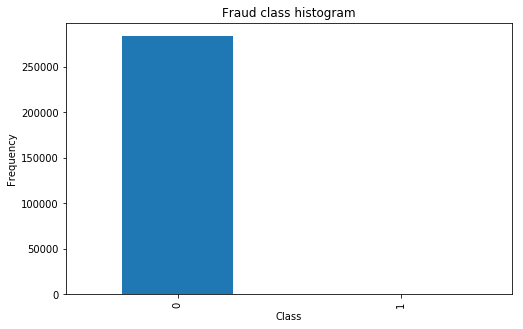

In [5]:
class_count = pd.value_counts(df.Class)
class_count.plot(figsize=(8,5), kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
print('Number of normal cases:\t{}\t({:.4f}%)'.format(class_count[0], class_count[0]/len(df)*100))
print('Number of fraud cases:\t{}\t({:.4f}%)'.format(class_count[1], class_count[1]/len(df)*100))

Since the dataset is highly unbalanced, we may use autoencoder to detect frauds.

In [6]:
%%html
<img src="autoencoder.png", width=500, hight=200 >

In [7]:
NUM_FEATURES = 30
DIM1 = 21
DIM2 = 14
DIM3 = 7    
    
class Autoencoder(nn.Module):
    def __init__(self, num_features, dim1, dim2, dim3, dropout=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential()
        self.encoder.add_module("layer1", nn.Linear(num_features, dim1))
#         self.encoder.add_module("dropout", torch.nn.Dropout(dropout))
        self.encoder.add_module("relu1", torch.nn.ReLU())
        self.encoder.add_module("layer2", nn.Linear(dim1, dim2))
#         self.encoder.add_module("dropout", torch.nn.Dropout(dropout))
        self.encoder.add_module("relu2", torch.nn.ReLU())
        self.encoder.add_module("layer3", nn.Linear(dim2, dim3))
#         self.encoder.add_module("dropout", torch.nn.Dropout(dropout))
        self.encoder.add_module("relu3", torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential()
        self.decoder.add_module("layer1", nn.Linear(dim3, dim2))
#         self.decoder.add_module("dropout", torch.nn.Dropout(dropout))
        self.decoder.add_module("relu1", torch.nn.ReLU())
        self.decoder.add_module("layer2", nn.Linear(dim2, dim1))
#         self.decoder.add_module("dropout", torch.nn.Dropout(dropout))
        self.decoder.add_module("relu2", torch.nn.ReLU())
        self.decoder.add_module("layer3", nn.Linear(dim1, num_features))
        self.decoder.add_module("relu3", torch.nn.ReLU())
        
    def forward(self, input_features):
        encoder_out = self.encoder(input_features)
        decoder_out = self.decoder(encoder_out)
        return decoder_out

    
autoencoder = Autoencoder(NUM_FEATURES, DIM1, DIM2, DIM3).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (layer1): Linear(in_features=30, out_features=21, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=21, out_features=14, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=14, out_features=7, bias=True)
    (relu3): ReLU()
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=7, out_features=14, bias=True)
    (relu1): ReLU()
    (layer2): Linear(in_features=14, out_features=21, bias=True)
    (relu2): ReLU()
    (layer3): Linear(in_features=21, out_features=30, bias=True)
    (relu3): ReLU()
  )
)


<font size="3">Since the features V1, V2, ..., V28 are the principal components obtained with PCA, that means they are already normalized to zero mean and unit variance. So we only need to normalize the features time and amount.</font>

In [0]:
df_scaled = df
df_scaled.Time = StandardScaler().fit_transform(df_scaled.Time.values.reshape(-1, 1))
df_scaled.Amount = StandardScaler().fit_transform(df_scaled.Amount.values.reshape(-1, 1))

In [0]:
BATCH_SIZE = 128
NUM_EPOCHS = 100
REG_MULTIPLIER = 0.3
RANDOM_SEED = 31
TEST_SIZE = 0.2

X_train, X_test = train_test_split(df_scaled, test_size=TEST_SIZE, random_state=RANDOM_SEED)
X_train_1 = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_train, X_val = train_test_split(X_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)


X_test = pd.concat([X_test, X_train_1], axis=0)
X_test = shuffle(X_test)
y_test = X_test['Class'].values
X_test = X_test.drop(['Class'], axis=1) 
X_test = X_test.values


training_samples = utils_data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_train))
validation_samples = utils_data.TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_val))
training_data_loader = utils_data.DataLoader(training_samples, batch_size=BATCH_SIZE, shuffle=True)	
validation_data_loader = utils_data.DataLoader(validation_samples, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
%%time

LOG_INTERVAL = 1000
PATH = './autoencoder_best.pth'
Loss_min = float('inf')
Loss_list = []

train_losses = []
def train(data_loader, optimizer, criterion, regulization=False, reg_multiplier=0.1):
    autoencoder.train()
    train_loss = 0
    for batch_idx, (input_features, target) in enumerate(data_loader):
        loss_list = []
        input_features, target = input_features.to(device), target.to(device)
        optimizer.zero_grad()
        output = autoencoder(input_features.float())
        
        reg = 0
        if regulization:
            reg = reg_multiplier * sum([torch.norm(param, 1) for param in autoencoder.parameters()])
            
        loss = criterion(output, target.float()) + reg
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
#         if batch_idx % LOG_INTERVAL == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch+1, batch_idx * len(input_features), len(data_loader.dataset),
#             100. * batch_idx / len(data_loader), loss.data.item()))
        
    train_loss = train_loss * (data_loader.batch_size / len(data_loader.dataset))
    print('\nTrain Epoch: {}/{}\tLoss: {:.4f}'.format(epoch+1, NUM_EPOCHS, train_loss))
    train_losses.append(train_loss)
    
    
minLoss = float('inf')    
val_losses = []    
def validate(data_loader, criterion):
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (input_features, target) in enumerate(data_loader):
            input_features, target = input_features.to(device), target.to(device)
            output = autoencoder(input_features.float())
            val_loss += criterion(output, target.float()).item()
    val_loss = val_loss * (data_loader.batch_size / len(data_loader.dataset))
    val_losses.append(val_loss)
    print('Validation \t\tLoss: {:.4f}'.format(val_loss))
    return val_loss
    

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

for epoch in range(NUM_EPOCHS):
    train(training_data_loader, optimizer, criterion)
    val_loss = validate(validation_data_loader, criterion)
    if val_loss < minLoss:
        torch.save({
#             'epoch': epoch,
            'model_state_dict': autoencoder.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, PATH)
        print('Validation loss decreased from {} to {}, saving model to {}'.format(minLoss, val_loss, PATH))
        minLoss = val_loss


Train Epoch: 1/100	Loss: 0.8788
Validation 		Loss: 0.8295
Validation loss decreased from inf to 0.8295180981588606, saving model to ./autoencoder_best.pth

Train Epoch: 2/100	Loss: 0.7928
Validation 		Loss: 0.7794
Validation loss decreased from 0.8295180981588606 to 0.7794458632842233, saving model to ./autoencoder_best.pth

Train Epoch: 3/100	Loss: 0.7701
Validation 		Loss: 0.7707
Validation loss decreased from 0.7794458632842233 to 0.7707412996283939, saving model to ./autoencoder_best.pth

Train Epoch: 4/100	Loss: 0.7613
Validation 		Loss: 0.7632
Validation loss decreased from 0.7707412996283939 to 0.7632405219705203, saving model to ./autoencoder_best.pth

Train Epoch: 5/100	Loss: 0.7577
Validation 		Loss: 0.7610
Validation loss decreased from 0.7632405219705203 to 0.7609939878754348, saving model to ./autoencoder_best.pth

Train Epoch: 6/100	Loss: 0.7551
Validation 		Loss: 0.7579
Validation loss decreased from 0.7609939878754348 to 0.7579364619381165, saving model to ./autoencode

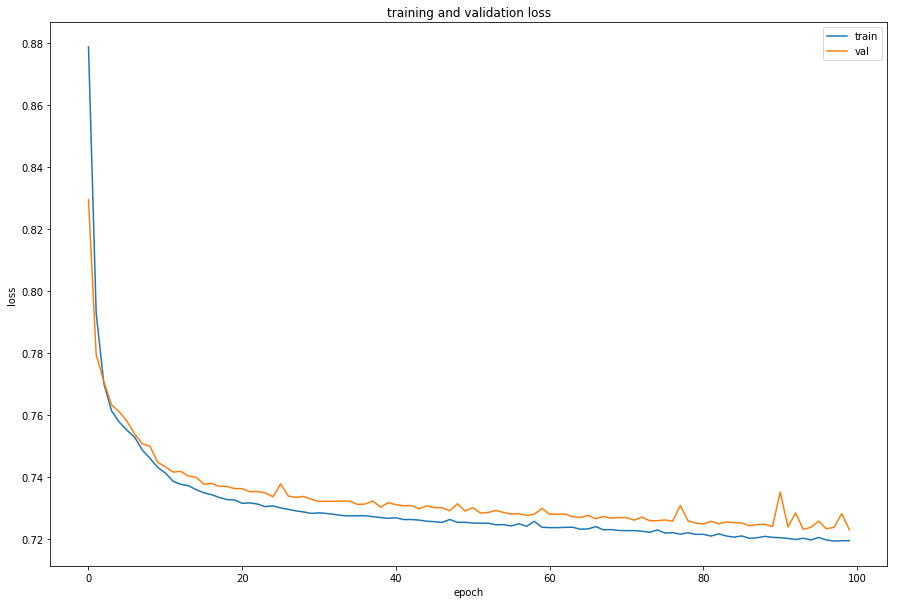

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train_losses)
ax.plot(val_losses)
ax.legend(['train', 'val'])
plt.title("training and validation loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [0]:
autoencoder_best = Autoencoder(NUM_FEATURES, DIM1, DIM2, DIM3).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())   

checkpoint = torch.load(PATH)
autoencoder_best.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
loss_best = checkpoint['loss']

autoencoder_best.eval()
autoencoder = autoencoder_best

In [13]:
autoencoder.eval()
X_test_pred = autoencoder(torch.tensor(X_test).float().to(device))
min_squared_error = np.mean(np.power(X_test - X_test_pred.cpu().detach().numpy(), 2), axis=1)
df_error = pd.DataFrame({'True_class': y_test,
                         'Reconstruction_error': min_squared_error})
df_error.Reconstruction_error.describe()

count    57352.000000
mean         0.932460
std          4.846206
min          0.044751
25%          0.269814
50%          0.421317
75%          0.667203
max        294.863095
Name: Reconstruction_error, dtype: float64

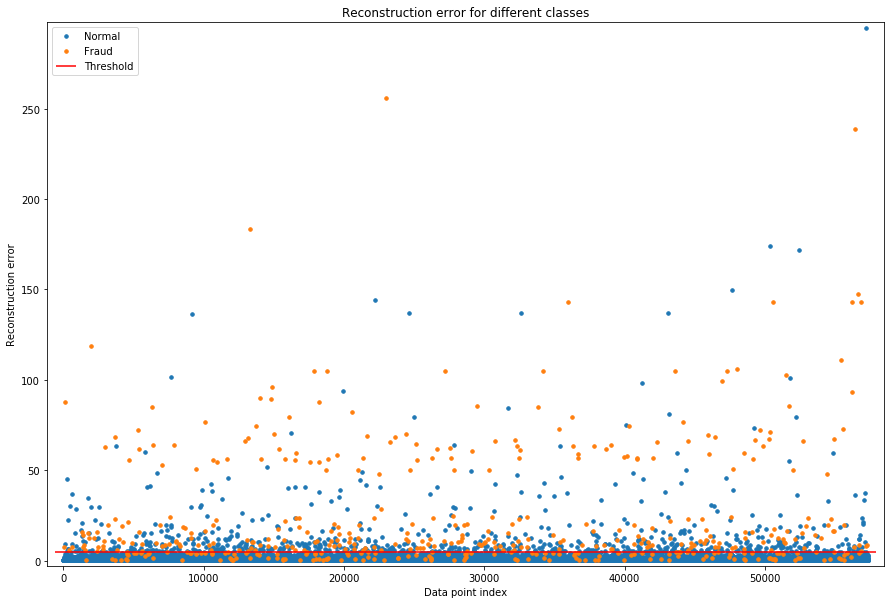

In [14]:
THRESHOLD = 5

groups = df_error.groupby('True_class')

fig, ax = plt.subplots(figsize=(15, 10))
# ax.figure(figsize=(12, 8))

for name, group in groups:
    ax.margins(x=0.01, y=0.01) 
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=3, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

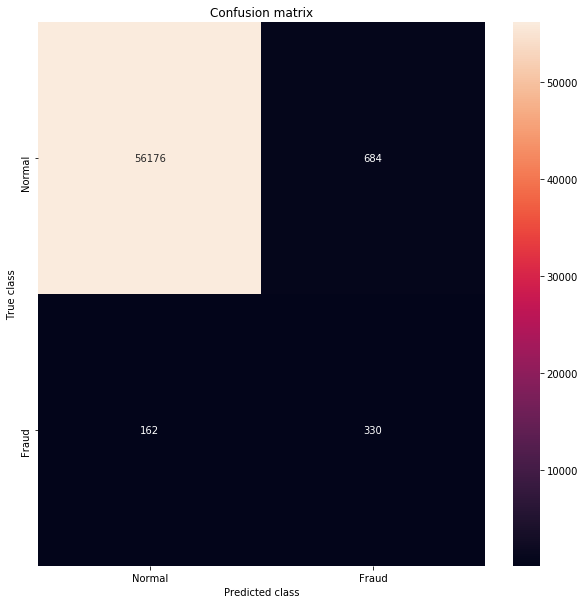

In [15]:
LABELS = ["Normal","Fraud"]

y_pred = [1 if e > THRESHOLD else 0 for e in df_error.Reconstruction_error.values]
conf_matrix = confusion_matrix(df_error.True_class, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [16]:
classification_report(y_test, y_pred, target_names=['fraud', 'normal']).split('\n')
f1_score(y_test, y_pred)

0.43824701195219123

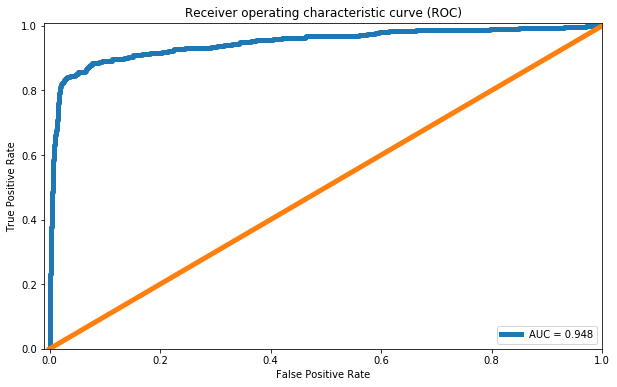

In [19]:
fpr, tpr, thresholds = roc_curve(df_error.True_class, df_error.Reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

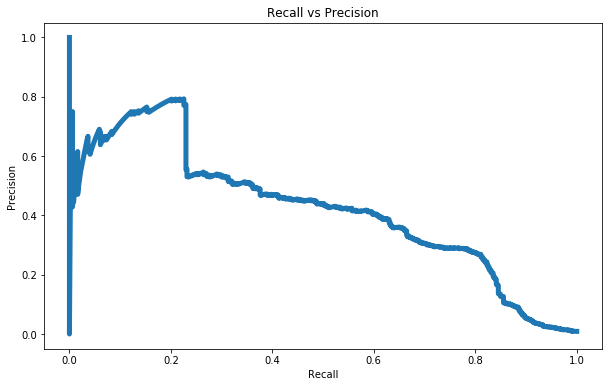

In [20]:
precision, recall, threshold = precision_recall_curve(df_error.True_class, df_error.Reconstruction_error)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

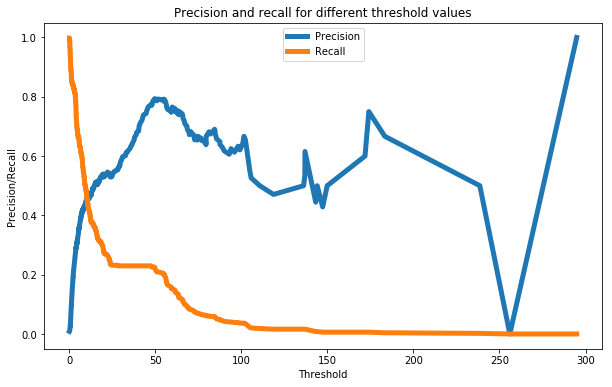

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()